# Estudos com Planejamento probabilístico

## 0 . Setup de ambiente

In [1]:
# prepara a máquina local do google colab para receber a base (quando necessário)
# e baixa os scripts auxiliares para a montagem do notebook
#!rm -rf ./*

#!git clone https://github.com/danielbdias/automated-planning-and-reinforcement-learning-studies
#!mv ./automated-planning-and-reinforcement-learning-studies/* ./
#!rm -rf ./automated-planning-and-reinforcement-learning-studies
#!rm -rf ./sample_data

#!pip install -r requirements.txt

In [2]:
import time
import pandas as pd
import numpy as np

from probabilistic_planning.problems.reader import read_problem_file
from probabilistic_planning.algorithms.value_iteration import enumerative_value_iteration
from probabilistic_planning.algorithms.rtdp import enumerative_rtdp, enumerative_lrtdp

epsilon = 1e-8
gamma = 0.9

# 1. Algoritmos de teste

In [8]:
def test_algorithm(algorithm_name, algorithm, mdp):
    start_time = time.time()

    policy, value_function, statistics = algorithm(mdp)

    elapsed_time = time.time() - start_time
    elapsed_time_as_string = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

    return {
        "algorithm_name": algorithm_name,
        "elapsed_time": elapsed_time,
        "elapsed_time_as_string": elapsed_time_as_string,
        "iterations": statistics["iterations"],
        "bellman_backups_done": statistics["bellman_backups_done"],
        "maximum_residuals": statistics["maximum_residuals"],
        "last_residual": float(statistics["maximum_residuals"][-1])
    }

def summarize_results(results):
    if len(results) == 1:
        return results[0]
  
    mean_elapsed_time = np.mean(list(map(lambda r: r["elapsed_time"], results)))
    mean_iterations = np.mean(list(map(lambda r: r["iterations"], results)))
    mean_bellman_backups_done = np.mean(list(map(lambda r: r["bellman_backups_done"], results)))

    best_results = sorted(results, key=lambda result: result["elapsed_time"] * result["last_residual"])
    best_result = best_results[0]

    return {
        "algorithm_name": best_result["algorithm_name"],
        "elapsed_time": mean_elapsed_time,
        "elapsed_time_as_string": time.strftime("%H:%M:%S", time.gmtime(mean_elapsed_time)),
        "iterations": mean_iterations,
        "bellman_backups_done": mean_bellman_backups_done,
        "maximum_residuals": best_result["maximum_residuals"],
        "last_residual": best_result["last_residual"]
    }

def test_algorithms_in_mdp(algorithms, mdp, times = 1):
    results = []

    for algorithm_name in algorithms.keys():
        algorithm = algorithms[algorithm_name]

        algorithm_results = list(map(lambda test_number: test_algorithm(algorithm_name, algorithm, mdp), range(times)))
        results.append(summarize_results(algorithm_results))

    dataframe = pd.DataFrame({
        "Algorithm": list(map(lambda result: result["algorithm_name"], results)),
        "Elapsed Time": list(map(lambda result: result["elapsed_time"], results)),
        "Elapsed Time String": list(map(lambda result: result["elapsed_time_as_string"], results)),
        "Iterations": list(map(lambda result: result["iterations"], results)),
        "Bellman Backups": list(map(lambda result: result["bellman_backups_done"], results)),
        "Last Residual": list(map(lambda result: result["last_residual"], results))
    })

    return results, dataframe

# 2. Experimentos

## 2.1 - Convergência

In [9]:
# algoritmos a serem testados
algorithms = {
    "Value Iteration": lambda mdp: enumerative_value_iteration(mdp, gamma=gamma, epsilon=epsilon),
    "RTDP": lambda mdp: enumerative_rtdp(mdp, gamma=gamma, max_trials=350, max_depth=2_000),
    "LRTDP": lambda mdp: enumerative_lrtdp(mdp, gamma=gamma, epsilon=epsilon, max_depth=2_000)
}

mdp_river_traversal_01 = read_problem_file(problem_file="probabilistic_planning/problems/files/enumerative/river_traversal_01.net")
raw_results_01, results_dataframe_01 = test_algorithms_in_mdp(algorithms, mdp_river_traversal_01, times = 5)
results_dataframe_01

,Algorithm,Elapsed Time,Elapsed Time String,Iterations,Bellman Backups,Last Residual
0,Value Iteration,0.451883,00:00:00,49.0,6125.0,6.946284e-09
1,RTDP,0.903147,00:00:00,350.0,3613.2,0.000000e+00
2,LRTDP,0.742862,00:00:00,193.4,2645.8,0.000000e+00


In [ ]:
# algoritmos a serem testados
algorithms = {
    "Value Iteration": lambda mdp: enumerative_value_iteration(mdp, gamma=gamma, epsilon=epsilon),
    "RTDP": lambda mdp: enumerative_rtdp(mdp, gamma=gamma, max_trials=350, max_depth=20_000),
    "LRTDP": lambda mdp: enumerative_lrtdp(mdp, gamma=gamma, epsilon=epsilon, max_depth=20_000)
}

mdp_river_traversal_02 = read_problem_file(problem_file="probabilistic_planning/problems/files/enumerative/river_traversal_02.net")
raw_results_02, results_dataframe_02 = test_algorithms_in_mdp(algorithms, mdp_river_traversal_02, times = 5)
results_dataframe_02

In [5]:
latex_results_dataframe_01 = results_dataframe_01[["Algorithm", "Elapsed Time", "Iterations", "Bellman Backups"]]
latex_results_dataframe_01.columns = [ "Algoritmo", "Tempo (em segundos)", "Iterações", "Bellman Backups" ]
latex_results_dataframe_01.T.to_latex()

'\\begin{tabular}{llll}\n\\toprule\n{} &                0 &        1 &       2 \\\\\n\\midrule\nAlgoritmo           &  Value Iteration &     RTDP &   LRTDP \\\\\nTempo (em segundos) &          3.36332 &  2.63117 &  2.2036 \\\\\nIterações           &               33 &      100 &    43.7 \\\\\nBellman Backups     &             4125 &   1440.4 &  1103.9 \\\\\n\\bottomrule\n\\end{tabular}\n'

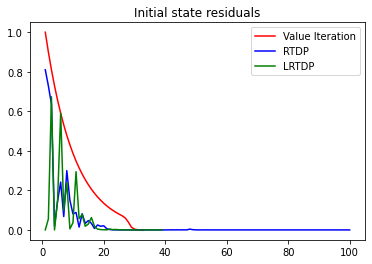

In [6]:
import matplotlib.pyplot as plt

point_types = [ 'r-', 'b-', 'g-' ]
algorithm_names = []

for i in range(len(raw_results_01)):
  result = raw_results_01[i]

  y = result["maximum_residuals"]
  x = range(1, len(result["maximum_residuals"]) + 1)
  point_type = point_types[i]
  algorithm_names.append(result["algorithm_name"])

  plt.plot(x, y, point_type)

plt.title("Initial state residuals")
plt.legend(algorithm_names)
plt.show()

## 2.3 - river_traversal_02

In [9]:
from probabilistic_planning.algorithms.policy_iteration import enumerative_policy_iteration

algorithms = {
    "RTDP": lambda mdp: enumerative_rtdp(mdp, gamma=gamma, max_trials=200, max_depth=2_000_000),
    #"LRTDP": lambda mdp: enumerative_lrtdp(mdp, gamma=gamma, epsilon=epsilon, max_depth=2_000_000)
}

mdp_river_traversal_02 = read_problem_file(problem_file="probabilistic_planning/problems/files/enumerative/river_traversal_02.net")
raw_results_02, results_dataframe_02 = test_algorithms_in_mdp(algorithms, mdp_river_traversal_02)
results_dataframe_02

KeyboardInterrupt: ignored

## 2.3 - river_traversal_03

In [ ]:
algorithms = {
    "RTDP": lambda mdp: enumerative_rtdp(mdp, gamma=gamma, epsilon=epsilon, max_trials=300, max_depth=2_000_000),
    #"LRTDP": lambda mdp: enumerative_lrtdp(mdp, gamma=gamma, epsilon=epsilon, max_depth=2_000_000)
}

#mdp_river_traversal_03 = read_problem_file(problem_file="probabilistic_planning/problems/files/enumerative/river_traversal_03.net")
#raw_results_03, results_dataframe_03 = test_algorithms_in_mdp(algorithms, mdp_river_traversal_02)
#results_dataframe_03